In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
import collections
from array import array

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/'
outputdir = inputdir+'xsec_all_2D_2_mar18/' 
output_filedir = outputdir
input_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')


Welcome to JupyROOT 6.18/04


In [2]:
pot_data =    7.644e+18

outputdir_png, outputdir_root, outputdir_pdf = NuCC.prepareOutput2(outputdir)
try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)
RootFile = ROOT.TFile(output_filedir+"xsec_genie_all_2D_2.root","RECREATE");


In [3]:
#!jupyter nbconvert --to script numuCCana_muon_cut_weight.ipynb

In [4]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# All Genie 2D cross section error calculation

In [5]:
##### flux and number of tragets parameters###
flux = 1.16859e11/1.592e20 # flux per POT per cm2
print flux
flux = 7.3789785277e-10
print flux
roh_data = 1.3836 #data denisity g/cm3
roh_MC = 1.3954 # MC denisity g/cm3
mol = 39.95 # g for argon
N_A = 6.022140857e23 # molec/mol avogadro zahl
N_nucleons = 40.0
V_fid = ((254.8-10)-(-1.55+10))*((117.47-10)-(-115.53+10))*((1036.9-50)-(-0.1+10))
print 'Fiducial Volume: ', V_fid
##############################################

beam_flux = flux * pot_data
print 'Beam flux = {:.5e}'.format(beam_flux),' /cm2'
N_tot = roh_data*N_A*N_nucleons*V_fid/mol
print 'Number of target nuclei= {:.5e}'.format(N_tot),' /cm3'

7.34038944724e-10
7.3789785277e-10
Fiducial Volume:  49184671.35
Beam flux = 5.64049e+09  /cm2
Number of target nuclei= 4.10331e+31  /cm3


In [6]:
def draw_adding():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/30.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/30.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

In [7]:
from array import array
#mom_bins = [ 0.00, 0.18, 0.30, 0.45, 0.77, 1.28, 2.50 ]
#mom_bins = [ 0.00, 0.225, 0.28, 0.33, 0.39, 0.52, 0.78, 1.21, 2.5]

mom_bins = {}
mom_bins[0] = [ 0.00, 0.18, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[1] = [ 0.00, 0.18, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[2] = [ 0.00, 0.18, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[3] = [ 0.00, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[4] = [ 0.00, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[5] = [ 0.00, 0.30, 0.45, 0.77, 2.50 ]
mom_bins[6] = [ 0.00, 0.30, 0.45, 0.77, 1.28, 2.50 ]
mom_bins[7] = [ 0.00, 0.30, 0.45, 0.77, 1.28, 2.50 ]
mom_bins[8] = [ 0.00, 0.30, 0.45, 0.77, 1.28, 2.50 ]

theta_bins = [ -1.00, -0.50, 0.00, 0.28, 0.47, 0.63, 0.765, 0.865, 0.935, 1.00 ]

len_theta = len(theta_bins) - 1
len_mom = {}
sum_bins = 0
for i in range(len_theta):
    len_mom[i] = len(mom_bins[i]) - 1
    #print len_mom[i]
    sum_bins+=len_mom[i]

num_universes = 100

In [8]:
path_all = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/'
f_all = ROOT.TFile.Open(path_all+"pc46_data/All_Genie_2D.root", 'read')

path_cv = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/'
f_cv = ROOT.TFile.Open(path_cv+"xsec_filesV4/xsec_2D_wighted.root", 'read')

# fix file: root -l
#            TFile *MyFile = new TFile("All_Genie_theta.root","UPDATE");
#           MyFile->Write()

In [9]:
# get data, ext and dirt from CV file
h_data = []
h_ext = []
h_dirt = []
h_overlay_cv = []
h_eff_tilde_cv = []

for t_bin in range(len_theta):
    h_data.append(f_cv.Get('h_data['+str(t_bin)+']'))
    h_ext.append(f_cv.Get('h_ext['+str(t_bin)+']'))
    h_dirt.append(f_cv.Get('h_dirt['+str(t_bin)+']'))
    h_overlay_cv.append(f_all.Get('h_overlay_cv['+str(t_bin)+']'))
    h_eff_tilde_cv.append(f_all.Get('h_1d_eff_tilde_cv['+str(t_bin)+']'))

print h_data[0].Integral(0,len_mom[0]+1)
print h_ext[0].Integral(0,len_mom[0]+1)
print h_dirt[0].Integral(0,len_mom[0]+1)
print h_eff_tilde_cv[0].Integral(0,len_mom[0]+1)

88.0
5.80717624724
11.4282898307
1.68261128664


In [10]:
# get background from all genie file
h_bkg = []

for uni in range(num_universes):
    h_bkg.append([])
    for t_bin in range(len_theta):
        h_bkg[uni].append(f_all.Get('h_overlay['+str(uni)+']['+str(t_bin)+']'))

In [11]:
# get background from all genie file
h_eff_tilde = []

for uni in range(num_universes):
    h_eff_tilde.append([])
    for t_bin in range(len_theta):
        h_eff_tilde[uni].append(f_all.Get('h_1d_eff_tilde['+str(uni)+']['+str(t_bin)+']'))

In [12]:
# calculate cv xsec
h_xsec_data_cv = []


for t_bin in range(len_theta):
    h_xsec_data_cv.append(h_data[t_bin].Clone())
    h_xsec_data_cv[t_bin].Add(h_ext[t_bin],-1)
    h_xsec_data_cv[t_bin].Add(h_dirt[t_bin],-1)
    h_xsec_data_cv[t_bin].Add(h_overlay_cv[t_bin],-1)

    h_xsec_data_cv[t_bin].Divide(h_eff_tilde_cv[t_bin])
    h_xsec_data_cv[t_bin].Scale(1.0/(N_tot*beam_flux*1e-38))

    for m_bin in range(len_mom[t_bin]):
        h_xsec_data_cv[t_bin].SetBinContent(m_bin+1,h_xsec_data_cv[t_bin].GetBinContent(m_bin+1)/h_xsec_data_cv[t_bin].GetBinWidth(m_bin+1))
        h_xsec_data_cv[t_bin].SetBinError(m_bin+1,h_xsec_data_cv[t_bin].GetBinError(m_bin+1)/h_xsec_data_cv[t_bin].GetBinWidth(m_bin+1))

    bin_width_theta = theta_bins[t_bin+1] - theta_bins[t_bin]
    h_xsec_data_cv[t_bin].Scale(1.0/bin_width_theta)

In [13]:
# calculate xsec for each universe
h_xsec_data = []

for uni in range(num_universes):
    h_xsec_data.append([])
    for t_bin in range(len_theta):
        h_xsec_data[uni].append(h_data[t_bin].Clone())
        h_xsec_data[uni][t_bin].Add(h_ext[t_bin],-1)
        h_xsec_data[uni][t_bin].Add(h_dirt[t_bin],-1)
        h_xsec_data[uni][t_bin].Add(h_bkg[uni][t_bin],-1)
        
        h_xsec_data[uni][t_bin].Divide(h_eff_tilde[uni][t_bin])
        h_xsec_data[uni][t_bin].Scale(1.0/(N_tot*beam_flux*1e-38))
        
        for m_bin in range(len_mom[t_bin]):
            h_xsec_data[uni][t_bin].SetBinContent(m_bin+1,h_xsec_data[uni][t_bin].GetBinContent(m_bin+1)/h_xsec_data[uni][t_bin].GetBinWidth(m_bin+1))
            h_xsec_data[uni][t_bin].SetBinError(m_bin+1,h_xsec_data[uni][t_bin].GetBinError(m_bin+1)/h_xsec_data[uni][t_bin].GetBinWidth(m_bin+1))
        
        bin_width_theta = theta_bins[t_bin+1] - theta_bins[t_bin]
        h_xsec_data[uni][t_bin].Scale(1.0/bin_width_theta)

0.713900730014
0.938726395369
0.946943432093
0.894673079252
1.65158110857
2.05514448881
2.76470285654
3.10366094112
2.29651576281


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/png/h_xsec_2D_0_all.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/pdf/h_xsec_2D_0_all.pdf has been created
Warning in <TFile::Append>: Replacing existing TH1: h_col2 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/png/h_xsec_2D_1_all.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/pdf/h_xsec_2D_1_all.pdf has been created
Warning in <TFile::Append>: Replacing existing TH1: h_col2 (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/png/h_xsec_2D_2_all.png has been created
Info in <TCanvas:

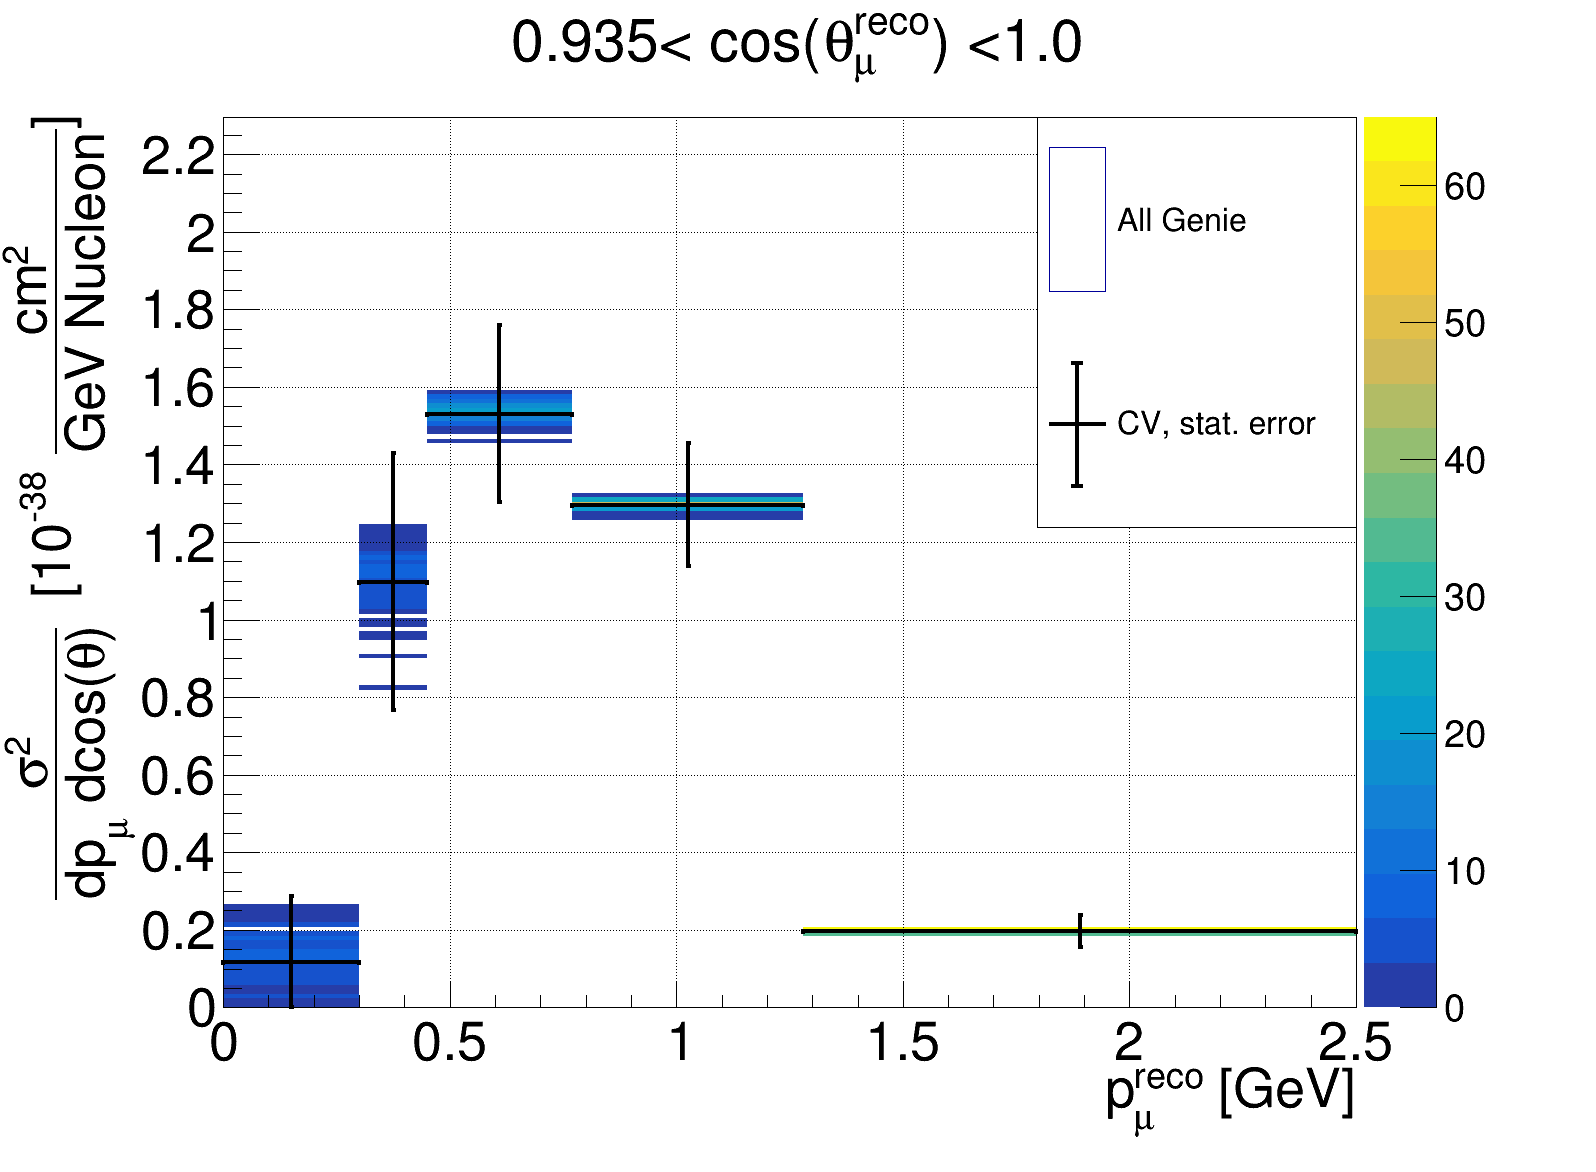

In [14]:
# draw all xsec


c1.SetRightMargin(0.15)
ROOT.gStyle.SetOptTitle(1)
for t_bin in range(len_theta): #len_theta
    #h_xsec_data[uni][t_bin].SetMaximum(-1111)
    h_xsec_data_cv[t_bin].SetMaximum(-1111)
    #h_xsec_data_cv[t_bin].SetMaximum(0)
    ybin = 200
    ystart = 0.0
    yend = h_xsec_data_cv[t_bin].GetMaximum()*1.5
    print yend
    y = np.arange(ystart, yend+(yend-ystart)/(ybin-1), (yend-ystart)/(ybin-1) ).tolist()
    h_col2 = ROOT.TH2D('h_col2','h_col2',len_mom[t_bin],array('f',mom_bins[t_bin]),ybin-1,array('f',y))
    h_col2.SetTitle(str(theta_bins[t_bin])+'< cos(#theta^{reco}_{#mu}) <'+str(theta_bins[t_bin+1]))
    h_col2.SetYTitle("#frac{#sigma^{2}}{dp_{#mu} dcos(#theta)} \t [10^{-38} #frac{cm^{2}}{GeV Nucleon}]")
    h_col2.SetXTitle("p^{reco}_{#mu} [GeV]")
    h_col2.GetYaxis().SetTitleSize(0.05)
    h_col2.GetYaxis().SetTitleOffset(0.0)
    h_col2.GetYaxis().SetLabelSize(0.05)
    h_col2.GetXaxis().SetTitleSize(0.05)
    h_col2.GetXaxis().SetLabelSize(0.05)
    h_col2.GetXaxis().SetTitleOffset(1)
    legend = ROOT.TLegend(0.65,0.55,0.85,0.9); #LEGEND RIGHT
    for uni in range(num_universes):
        for i in range(1,len_mom[t_bin]+1):
            h_col2.Fill(h_xsec_data[uni][t_bin].GetXaxis().GetBinCenter(i),h_xsec_data[uni][t_bin].GetBinContent(i))
    h_col2.Draw('colz')
    h_xsec_data_cv[t_bin].SetLineWidth(4)
    h_xsec_data_cv[t_bin].SetLineColor(ROOT.kBlack)
    h_xsec_data_cv[t_bin].Draw('E1 same')
    legend.AddEntry(h_col2,'All Genie',"f")
    legend.AddEntry(h_xsec_data_cv[t_bin],'CV, stat. error',"lep")
    legend.Draw()
    c1.SaveAs(outputdir_png + 'h_xsec_2D_'+str(t_bin)+'_all.png')
    #c1.SaveAs(globale.outputdir_root + 'h_xsec_2D_'+str(t_bin)+'_all.root')
    c1.SaveAs(outputdir_pdf + 'h_xsec_2D_'+str(t_bin)+'_all.pdf')

    c1.Draw()
            


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/png/h_xsec_2D_0_all.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/pdf/h_xsec_2D_0_all.pdf has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/png/h_xsec_2D_1_all.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/pdf/h_xsec_2D_1_all.pdf has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/png/h_xsec_2D_2_all.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/pdf/h_xsec_2D_2_all.pdf has been created
Info in <TCanvas::Prin

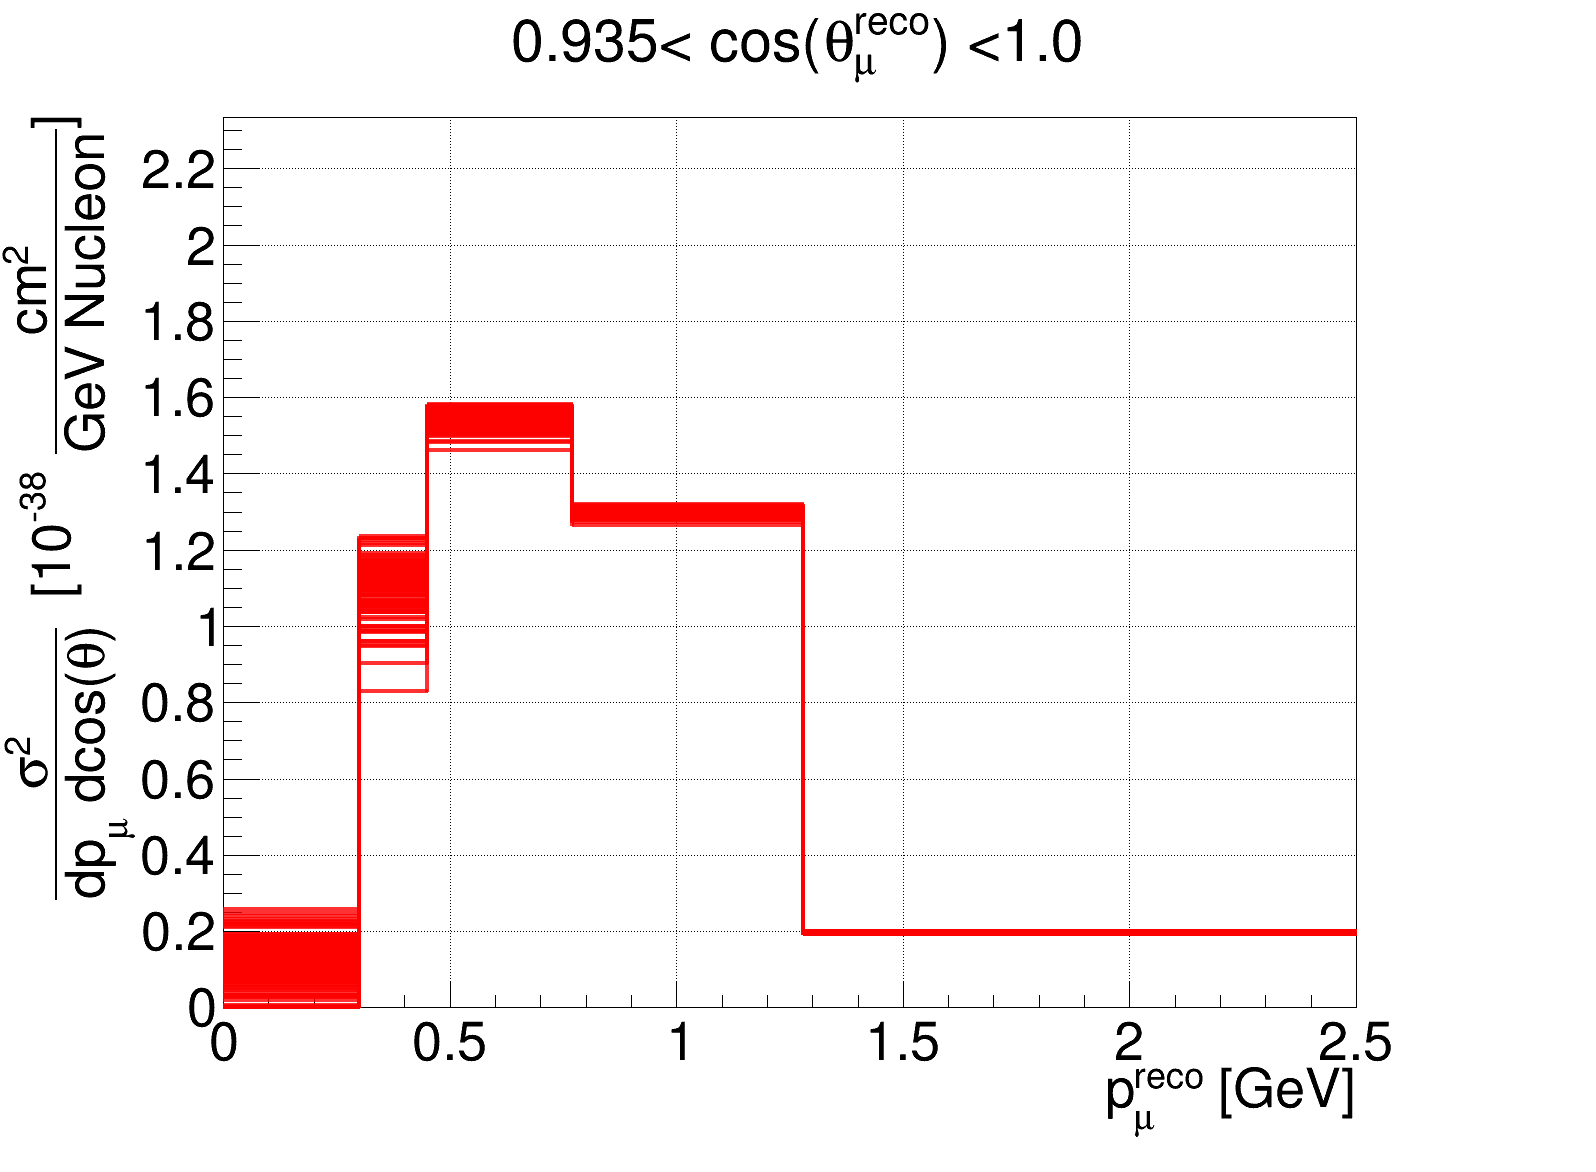

In [15]:
# draw all xsec

ROOT.gStyle.SetOptTitle(1)
for t_bin in range(len_theta): #len_theta
    legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
    for uni in range(num_universes):
        #legend.AddEntry(h_xsec_data[uni][t_bin],name_files[i],"f")
        h_xsec_data[uni][t_bin].SetLineColorAlpha(2,0.8)
        h_xsec_data[uni][t_bin].GetYaxis().SetTitleSize(0.05)
        h_xsec_data[uni][t_bin].GetYaxis().SetTitleOffset(0.0)
        h_xsec_data[uni][t_bin].GetYaxis().SetLabelSize(0.05)
        h_xsec_data[uni][t_bin].GetXaxis().SetTitleSize(0.05)
        h_xsec_data[uni][t_bin].GetXaxis().SetLabelSize(0.05)
        h_xsec_data[uni][t_bin].GetXaxis().SetTitleOffset(1)
        h_xsec_data[uni][t_bin].SetLineWidth(4)
        if(uni == 0):
            h_xsec_data[uni][t_bin].SetTitle(str(theta_bins[t_bin])+'< cos(#theta^{reco}_{#mu}) <'+str(theta_bins[t_bin+1]))
            h_xsec_data[uni][t_bin].SetXTitle("p^{reco}_{#mu} [GeV]")
            h_xsec_data[uni][t_bin].SetYTitle('#frac{#sigma^{2}}{dp_{#mu} dcos(#theta)} \t [10^{-38} #frac{cm^{2}}{GeV Nucleon}]')
            h_xsec_data[uni][t_bin].SetMaximum(-1111)
            h_xsec_data[uni][t_bin].SetMinimum(0)
            h_xsec_data[uni][t_bin].SetMaximum( h_xsec_data[uni][t_bin].GetMaximum()*1.5)
            h_xsec_data[uni][t_bin].Draw('hist')
        else:
            h_xsec_data[uni][t_bin].Draw('hist same')
    c1.SaveAs(outputdir_png + 'h_xsec_2D_'+str(t_bin)+'_all.png')
    #c1.SaveAs(globale.outputdir_root + 'h_xsec_2D_'+str(t_bin)+'_all.root')
    c1.SaveAs(outputdir_pdf + 'h_xsec_2D_'+str(t_bin)+'_all.pdf')

    c1.Draw()
            


In [16]:
xsec_cv_vec = np.zeros((sum_bins))
xsec_vec = np.zeros((num_universes,sum_bins))
xsec_diff_vec = np.zeros((num_universes,sum_bins))

bin_counter=0
for t_bin in range(len_theta): #len_theta
    for m_bin in range(len_mom[t_bin]):
        xsec_cv_vec[bin_counter] = h_xsec_data_cv[t_bin].GetBinContent(m_bin+1)
        bin_counter+=1
#print xsec_cv_vec
for uni in range(num_universes):
    bin_counter=0
    for t_bin in range(len_theta): #len_theta
        for m_bin in range(len_mom[t_bin]):
            xsec_vec[uni][bin_counter] = h_xsec_data[uni][t_bin].GetBinContent(m_bin+1)
            xsec_diff_vec[uni][bin_counter] = xsec_vec[uni][bin_counter] - xsec_cv_vec[bin_counter]
            bin_counter+=1
xsec_diff = xsec_diff_vec.mean(axis=0)
print xsec_diff_vec.mean(axis=0)

[ 4.15691447e-03  1.67017728e-02  2.49223769e-03  1.74894873e-04
  0.00000000e+00  4.69175412e-03  1.58938468e-03 -2.17085004e-03
 -7.78584927e-05  0.00000000e+00 -6.80525683e-03 -3.21003199e-03
 -6.51476920e-03 -1.70607939e-03 -4.46186308e-05  1.66447610e-03
 -3.55702460e-03 -3.09575260e-03 -3.48584680e-05  6.67467822e-03
 -4.80527103e-03 -3.84684324e-03 -9.30660032e-05  1.46595773e-02
  2.30888963e-03 -2.28761554e-03 -2.31800973e-05  7.69022943e-03
  1.74973488e-03 -8.55989456e-03  1.76876783e-05 -2.19542067e-05
  9.42927718e-03  6.28423929e-03  6.67937756e-03  3.18104982e-03
  1.42980814e-04  3.66477124e-03  1.45737529e-03  6.78118944e-03
  2.60235548e-03  3.86015922e-04]


In [17]:
cov_matrix = np.zeros((sum_bins,sum_bins))
for i in range(sum_bins):
    for j in range(sum_bins):
        for uni in range(num_universes):
            cov_matrix[i][j] = cov_matrix[i][j]+xsec_diff_vec[uni][i]*xsec_diff_vec[uni][j]
        cov_matrix[i][j] = cov_matrix[i][j]/num_universes


In [18]:
#cov_matrix = np.zeros((sum_bins,sum_bins))#
#
#for i in range(sum_bins):
#    for j in range(sum_bins):
#        cov_matrix[i][j] = xsec_diff[i]*xsec_diff[j]

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/png/h_covariance_allsys.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/root/h_covariance_allsys.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/pdf/h_covariance_allsys.pdf has been created


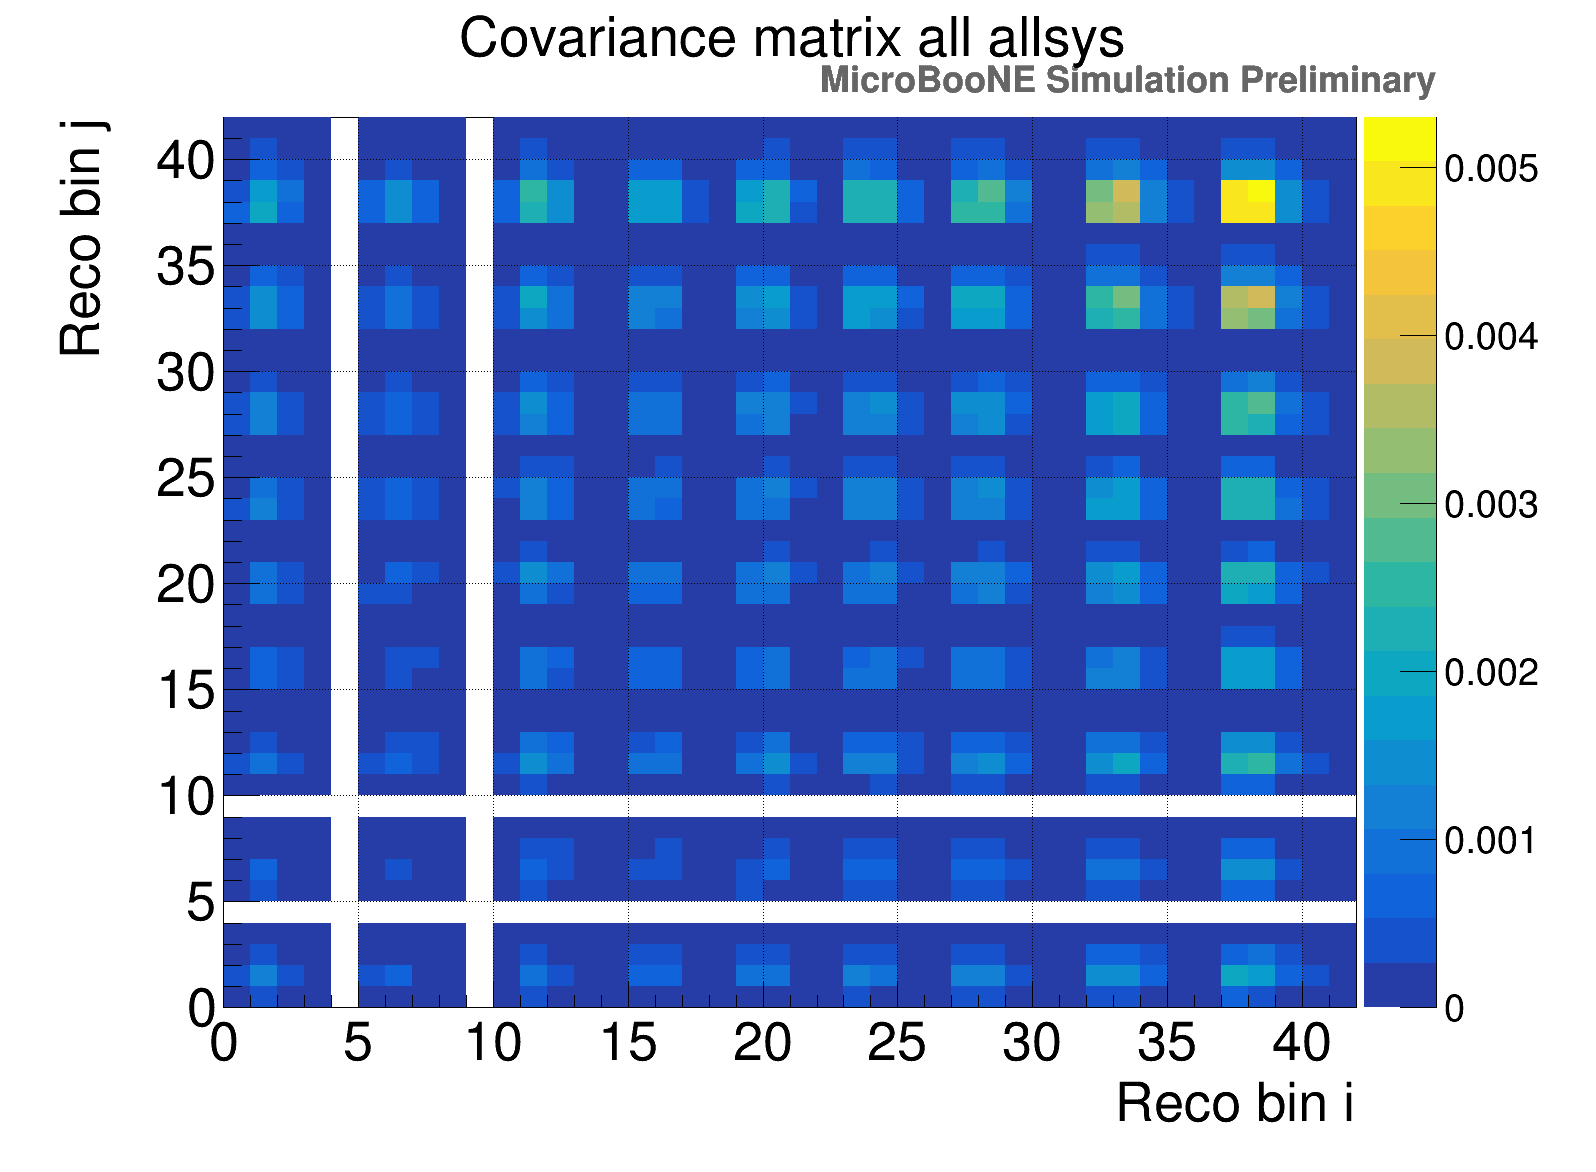

In [19]:
ROOT.gStyle.SetPaintTextFormat('0.6g')
h_covariance = ROOT.TH2D("h_covariance",'Covariance matrix all allsys',sum_bins,0,sum_bins,sum_bins,0,sum_bins)
for i in range(sum_bins):
    for j in range(sum_bins):
        h_covariance.SetBinContent(i+1,j+1,cov_matrix[i,j])
#h_covariance.SetXTitle("Reco bin i, 7=overflow")
#h_covariance.SetYTitle("True bin j")
h_covariance.SetXTitle("Reco bin i")
h_covariance.SetYTitle("Reco bin j")

h_covariance.GetYaxis().SetTitleSize(0.05)
h_covariance.GetYaxis().SetTitleOffset(0.0)
h_covariance.GetYaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleSize(0.05)
h_covariance.GetXaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleOffset(1)
h_covariance.SetLineColor(ROOT.kBlack)
h_covariance.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.15)
ROOT.gStyle.SetPaintTextFormat('0.4g')

h_covariance.Draw('colz')
#h_covariance.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_covariance_allsys.png")
c1.SaveAs(outputdir_root + "h_covariance_allsys.root")
c1.SaveAs(outputdir_pdf + "h_covariance_allsys.pdf")
#h_covariance.Write('h_covariance')
RootFile = ROOT.TFile(output_filedir+"All_systematic_2D.root","recreate");
h_covariance.Write('h_covariance')
RootFile.Close()  

In [20]:
#correlation matrix
xsec_corr_matrix = np.zeros((sum_bins,sum_bins))
for i in range(sum_bins):
    for j in range(sum_bins):
        xsec_corr_matrix[i][j] = cov_matrix[i][j]/(1e-80+math.sqrt(cov_matrix[i][i]*cov_matrix[j][j]))

#frac covariance matrix
xsec_frac_matrix = np.zeros((sum_bins,sum_bins))
for i in range(sum_bins):
    for j in range(sum_bins):
        #print cov_matrix[i][j]
        xsec_frac_matrix[i][j] = cov_matrix[i][j]/(1e-80+(xsec_cv_vec[i]*xsec_cv_vec[j]))


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/png/h_correlation_allsys.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/root/h_correlation_allsys.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/pdf/h_correlation_allsys.pdf has been created


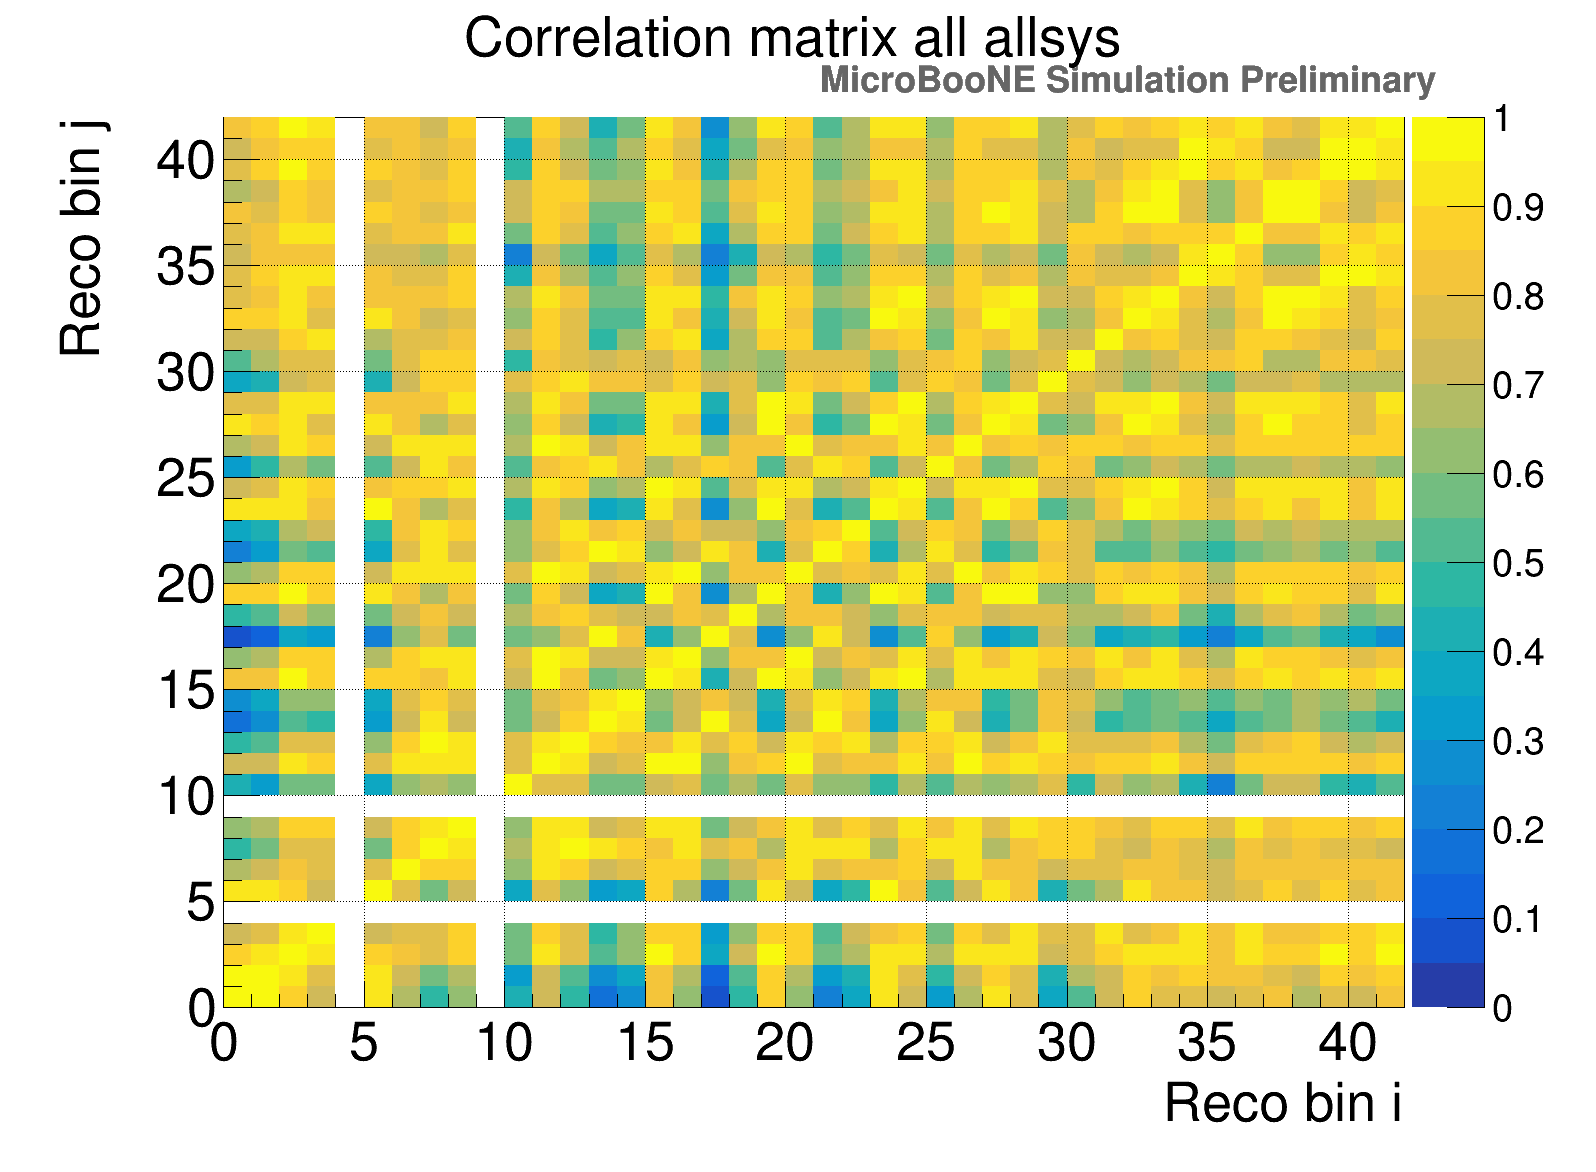

In [21]:
ROOT.gStyle.SetPaintTextFormat('0.6g')
h_covariance = ROOT.TH2D("h_covariance",'Correlation matrix all allsys',sum_bins,0,sum_bins,sum_bins,0,sum_bins)
for i in range(sum_bins):
    for j in range(sum_bins):
        h_covariance.SetBinContent(i+1,j+1,xsec_corr_matrix[i,j])
#h_covariance.SetXTitle("Reco bin i, 7=overflow")
#h_covariance.SetYTitle("True bin j")
h_covariance.SetXTitle("Reco bin i")
h_covariance.SetYTitle("Reco bin j")

h_covariance.GetYaxis().SetTitleSize(0.05)
h_covariance.GetYaxis().SetTitleOffset(0.0)
h_covariance.GetYaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleSize(0.05)
h_covariance.GetXaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleOffset(1)
h_covariance.SetLineColor(ROOT.kBlack)
h_covariance.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.12)
ROOT.gStyle.SetPaintTextFormat('0.4g')

h_covariance.Draw('colz')
#h_covariance.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_correlation_allsys.png")
c1.SaveAs(outputdir_root + "h_correlation_allsys.root")
c1.SaveAs(outputdir_pdf + "h_correlation_allsys.pdf")
#h_covariance.Write('h_covariance')
RootFile = ROOT.TFile(output_filedir+"All_systematic_2D.root","update");
h_covariance.Write('h_correlation')
RootFile.Close()  

Warning in <TROOT::Append>: Replacing existing TH1: h_covariance (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/png/h_frac_allsys.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/root/h_frac_allsys.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/pdf/h_frac_allsys.pdf has been created


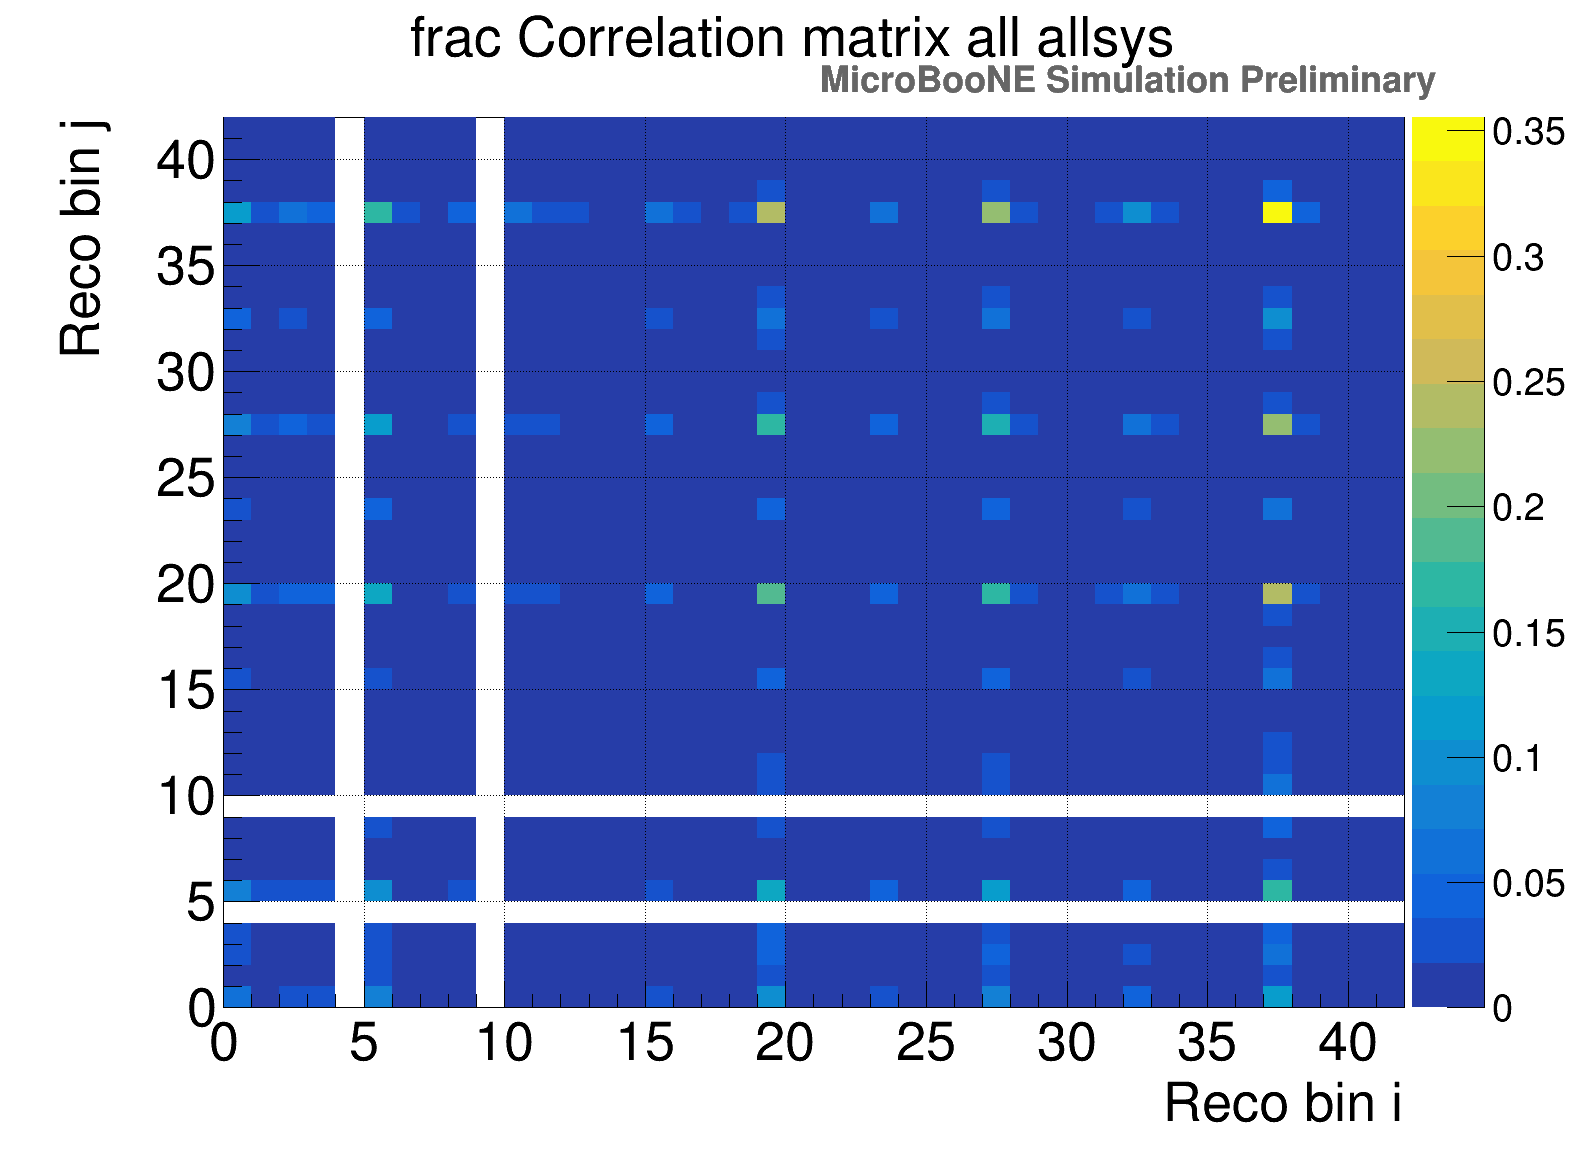

In [22]:
ROOT.gStyle.SetPaintTextFormat('0.6g')
h_covariance = ROOT.TH2D("h_covariance",'frac Correlation matrix all allsys',sum_bins,0,sum_bins,sum_bins,0,sum_bins)
for i in range(sum_bins):
    for j in range(sum_bins):
        h_covariance.SetBinContent(i+1,j+1,xsec_frac_matrix[i,j])
#h_covariance.SetXTitle("Reco bin i, 7=overflow")
#h_covariance.SetYTitle("True bin j")
h_covariance.SetXTitle("Reco bin i")
h_covariance.SetYTitle("Reco bin j")

h_covariance.GetYaxis().SetTitleSize(0.05)
h_covariance.GetYaxis().SetTitleOffset(0.0)
h_covariance.GetYaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleSize(0.05)
h_covariance.GetXaxis().SetLabelSize(0.05)
h_covariance.GetXaxis().SetTitleOffset(1)
h_covariance.SetLineColor(ROOT.kBlack)
h_covariance.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.12)
ROOT.gStyle.SetPaintTextFormat('0.4g')

h_covariance.Draw('colz')
#h_covariance.Draw('same text')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_frac_allsys.png")
c1.SaveAs(outputdir_root + "h_frac_allsys.root")
c1.SaveAs(outputdir_pdf + "h_frac_allsys.pdf")
#h_covariance.Write('h_covariance')
RootFile = ROOT.TFile(output_filedir+"All_systematic_2D.root","update");
h_covariance.Write('h_frac_covariance')
RootFile.Close()  

In [23]:
# draw all xsec
c1.SetRightMargin(0.15)
ROOT.gStyle.SetOptTitle(1)

bin_counter = 0

for t_bin in range(len_theta): #len_theta
    h_xsec_data_cv[t_bin].SetMaximum(-1111)
    ybin = 200
    ystart = 0.0
    yend = h_xsec_data_cv[t_bin].GetMaximum()*1.5
    y = np.arange(ystart, yend+(yend-ystart)/(ybin-1), (yend-ystart)/(ybin-1) ).tolist()
    h_col2 = ROOT.TH2D('h_col2','h_col2',len_mom[t_bin],array('f',mom_bins[t_bin]),ybin-1,array('f',y))
    h_col2.SetTitle(str(theta_bins[t_bin])+'< cos(#theta^{reco}_{#mu}) <'+str(theta_bins[t_bin+1]))
    h_col2.SetYTitle("#frac{#sigma^{2}}{dp_{#mu} dcos(#theta)} \t [10^{-38} #frac{cm^{2}}{GeV Nucleon}]")
    h_col2.SetXTitle("p^{reco}_{#mu} [GeV]")
    h_col2.GetYaxis().SetTitleSize(0.05)
    h_col2.GetYaxis().SetTitleOffset(0.0)
    h_col2.GetYaxis().SetLabelSize(0.05)
    h_col2.GetXaxis().SetTitleSize(0.05)
    h_col2.GetXaxis().SetLabelSize(0.05)
    h_col2.GetXaxis().SetTitleOffset(1)

    legend = ROOT.TLegend(0.55,0.65,0.9,0.9); #LEGEND RIGHT
    c1 = ROOT.TCanvas("c1","c1",1600,1200)
    c1.SetGrid(1)
    c1.SetLeftMargin(0.14)
    c1.SetRightMargin(0.1)
    c1.SetBottomMargin(0.1)

    c1.cd()
    pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
    pad1.SetGrid(1)
    pad1.Draw()
    pad1.cd()
    pad1.SetBottomMargin(0.03);
    pad1.SetTopMargin(0.1)

    h_xsec_this = h_xsec_data_cv[t_bin].Clone()
    legend.AddEntry(h_xsec_this,'CV, sys. err. AllGenie',"f")
    #legend.AddEntry(h_col2,'Genie All',"f")
    
    for uni in range(num_universes):
        for i in range(1,len_mom[t_bin]+1):
            h_col2.Fill(h_xsec_data[uni][t_bin].GetXaxis().GetBinCenter(i),h_xsec_data[uni][t_bin].GetBinContent(i))
    h_col2.GetYaxis().SetLabelSize(0.05);
    h_col2.GetYaxis().SetTitleSize(0.05);
    h_col2.GetYaxis().SetTitleOffset(0.8);
    h_col2.GetXaxis().SetLabelOffset(999);
    h_col2.GetXaxis().SetTitleOffset(999);
    h_col2.GetXaxis().SetLabelSize(0);
    h_col2.GetXaxis().SetTitleSize(0);
    h_col2.Draw('colz')
    for m_bin in range(len_mom[t_bin]):
        h_xsec_this.SetBinError(m_bin+1,math.sqrt(cov_matrix[bin_counter][bin_counter]))
        bin_counter+=1
    h_xsec_this.Draw('E1 same')
    legend.Draw()
    
    c1.cd()
    h_xsec_this.GetXaxis().SetLabelOffset(0);
    h_xsec_this.GetXaxis().SetTitleOffset(0);
    pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
    pad2.SetGrid(1)
    pad2.SetTopMargin(0.04)
    pad2.SetBottomMargin(0.4)
    pad2.Draw()
    pad2.cd()
    h_xsec_this_2 = h_xsec_this.Clone()
    h_xsec_this_2.Divide(h_xsec_this)
    h_xsec_this_2.SetTitle(' ')
    h_xsec_this_2.SetYTitle('Data/(Ext+MC)')
    h_xsec_this_2.GetYaxis().SetTitleSize(0.1)
    h_xsec_this_2.GetYaxis().SetTitleOffset(0.3)
    h_xsec_this_2.GetYaxis().SetLabelSize(0.07)

    h_xsec_this_2.GetXaxis().SetTitleSize(0.15)
    h_xsec_this_2.GetXaxis().SetLabelSize(0.15)
    h_xsec_this_2.GetXaxis().SetTitleOffset(1)
    h_xsec_this_2.SetMinimum(-1111)
    h_xsec_this_2.SetMaximum(-1111)
    h_xsec_this_2.Draw('e1')

    c1.SaveAs(outputdir_png + 'h_xsec_2D_'+str(t_bin)+'_all_sys.png')
    #c1.SaveAs(globale.outputdir_root + 'h_xsec_2D_'+str(t_bin)+'_all.root')
    c1.SaveAs(outputdir_pdf + 'h_xsec_2D_'+str(t_bin)+'_all_sys.pdf')

    c1.Draw()
            
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/png/h_xsec_2D_0_all_sys.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/pdf/h_xsec_2D_0_all_sys.pdf has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_col2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/png/h_xsec_2D_1_all_sys.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted_improved/xsec_all_2D_2_mar18/pdf/h_xsec_2D_1_all_sys.pdf has been created
Warning in <TROOT::Append>: Replacing existing TH1: h_col2 (Potential memory leak).
Warning in <TCanvas::Con

In [24]:
# close the root file with all the histos
RootFile.Close()